In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm

import torch
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from torch.utils.data import RandomSampler
from torch.utils.data import SequentialSampler

import transformers

from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

from seqeval.metrics import accuracy_score
from seqeval.metrics import f1_score
from tqdm import trange

torch.__version__

Using TensorFlow backend.


'1.5.0+cu101'

### PyTorch Config

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla P100-PCIE-16GB'

### Data Loading

In [3]:
data = pd.read_csv('ner_dataset.csv',
                   encoding='latin1').fillna(method='ffill')
data.head()

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O


In [0]:
class SentenceGetter(object):

    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["Word"].values.tolist(),
                                                           s["POS"].values.tolist(),
                                                           s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]

    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None


In [0]:
getter = SentenceGetter(data)

In [8]:
sentences = [[word[0] for word in sentence] for sentence in getter.sentences]
print(sentences[0])

['Thousands', 'of', 'demonstrators', 'have', 'marched', 'through', 'London', 'to', 'protest', 'the', 'war', 'in', 'Iraq', 'and', 'demand', 'the', 'withdrawal', 'of', 'British', 'troops', 'from', 'that', 'country', '.']


In [9]:
labels = [[s[2] for s in sentence] for sentence in getter.sentences]
print(labels[0])

['O', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-gpe', 'O', 'O', 'O', 'O', 'O']


In [11]:
tag_values = list(set(data["Tag"].values))
tag_values.append("PAD")
tag2idx = {t: i for i, t in enumerate(tag_values)}
tag2idx

{'B-art': 13,
 'B-eve': 4,
 'B-geo': 8,
 'B-gpe': 7,
 'B-nat': 10,
 'B-org': 12,
 'B-per': 2,
 'B-tim': 1,
 'I-art': 14,
 'I-eve': 0,
 'I-geo': 16,
 'I-gpe': 3,
 'I-nat': 5,
 'I-org': 9,
 'I-per': 11,
 'I-tim': 15,
 'O': 6,
 'PAD': 17}

In [0]:
## Hyperparams
MAX_LEN = 75
batch_size = 32

### Data Preprocessing

In [0]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-cased', do_lower_case=False)

In [0]:
def tokenize_and_preserve_labels(sentence, text_labels):
    tokenized_sentence = []
    labels = []

    for word, label in zip(sentence, text_labels):

        tokenized_word = tokenizer.tokenize(word)
        n_subwords = len(tokenized_word)

        tokenized_sentence.extend(tokenized_word)

        labels.extend([label] * n_subwords)

    return tokenized_sentence, labels


In [0]:
tokenized_texts_and_labels = [
    tokenize_and_preserve_labels(sent, labs)
    for sent, labs in zip(sentences, labels)
]

In [0]:
tokenized_texts = [token_label_pair[0] for token_label_pair in tokenized_texts_and_labels]
labels = [token_label_pair[1] for token_label_pair in tokenized_texts_and_labels]

In [0]:
input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts],
                          maxlen=MAX_LEN, dtype="long", value=0.0,
                          truncating="post", padding="post")

In [0]:
tags = pad_sequences([[tag2idx.get(l) for l in lab] for lab in labels],
                     maxlen=MAX_LEN, value=tag2idx["PAD"], padding="post",
                     dtype="long", truncating="post")

In [0]:
attention_masks = [[float(i != 0.0) for i in ii] for ii in input_ids]

In [0]:
tr_inputs, val_inputs, tr_tags, val_tags = train_test_split(input_ids, tags,
                                                            random_state=42069, test_size=0.1)
tr_masks, val_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=42069, test_size=0.1)

### Data -->  Tensors

In [0]:
tr_inputs = torch.tensor(tr_inputs)
val_inputs = torch.tensor(val_inputs)
tr_tags = torch.tensor(tr_tags)
val_tags = torch.tensor(val_tags)
tr_masks = torch.tensor(tr_masks)
val_masks = torch.tensor(val_masks)

### PyTorch DataLoader

In [0]:
train_data = TensorDataset(tr_inputs, tr_masks, tr_tags)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

valid_data = TensorDataset(val_inputs, val_masks, val_tags)
valid_sampler = SequentialSampler(valid_data)
valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=batch_size)

### Initializing BERT (base, cased)

In [0]:
model = transformers.BertForTokenClassification.from_pretrained(
    "bert-base-cased",
    num_labels=len(tag2idx),
    output_attentions = False,
    output_hidden_states = False
)

In [25]:
model.cuda()

BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwis

### Fine-tuning Hyperparameters

In [0]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
      'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
      'weight_decay_rate': 0.0}
]

In [0]:
optimizer = transformers.AdamW(optimizer_grouped_parameters, lr=3e-5, eps=1e-8)

In [0]:
from transformers import get_linear_schedule_with_warmup

epochs = 3
max_grad_norm = 1.0

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

### Train BERT

In [29]:
## Store the average loss after each epoch so we can plot them.
loss_values, validation_loss_values = [], []

for _ in trange(epochs, desc="Epoch"):
    # ========================================
    #               Training
    # ========================================
    # Perform one full pass over the training set.

    # Put the model into training mode.
    model.train()
    # Reset the total loss for this epoch.
    total_loss = 0

    # Training loop
    for step, batch in enumerate(train_dataloader):
        # add batch to gpu
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        # Always clear any previously calculated gradients before performing a backward pass.
        model.zero_grad()
        # forward pass
        # This will return the loss (rather than the model output)
        # because we have provided the `labels`.
        outputs = model(b_input_ids, token_type_ids=None,
                        attention_mask=b_input_mask, labels=b_labels)
        # get the loss
        loss = outputs[0]
        # Perform a backward pass to calculate the gradients.
        loss.backward()
        # track train loss
        total_loss += loss.item()
        # Clip the norm of the gradient
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=max_grad_norm)
        # update parameters
        optimizer.step()
        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)
    print("Average train loss: {}".format(avg_train_loss))

    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)


    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    # Put the model into evaluation mode
    model.eval()
    # Reset the validation loss for this epoch.
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    predictions , true_labels = [], []
    for batch in valid_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        # Telling the model not to compute or store gradients,
        # saving memory and speeding up validation
        with torch.no_grad():
            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have not provided labels.
            outputs = model(b_input_ids, token_type_ids=None,
                            attention_mask=b_input_mask, labels=b_labels)
        # Move logits and labels to CPU
        logits = outputs[1].detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences.
        eval_loss += outputs[0].mean().item()
        predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
        true_labels.extend(label_ids)

    eval_loss = eval_loss / len(valid_dataloader)
    validation_loss_values.append(eval_loss)
    print("Validation loss: {}".format(eval_loss))
    pred_tags = [tag_values[p_i] for p, l in zip(predictions, true_labels)
                                 for p_i, l_i in zip(p, l) if tag_values[l_i] != "PAD"]
    valid_tags = [tag_values[l_i] for l in true_labels
                                  for l_i in l if tag_values[l_i] != "PAD"]
    print("Validation Accuracy: {}".format(accuracy_score(pred_tags, valid_tags)))
    print("Validation F1-Score: {}".format(f1_score(pred_tags, valid_tags)))
    print()


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Average train loss: 0.18960450102800877
Validation loss: 0.13779307608803112
Validation Accuracy: 0.9574096555853054


Epoch:  33%|███▎      | 1/3 [06:11<12:23, 371.82s/it]

Validation F1-Score: 0.8123193641618498

Average train loss: 0.10807154508510548
Validation loss: 0.1316731454183658
Validation Accuracy: 0.9601453493206499


Epoch:  67%|██████▋   | 2/3 [12:23<06:11, 371.89s/it]

Validation F1-Score: 0.8288206707114613

Average train loss: 0.08157335130223042
Validation loss: 0.13179464516540368
Validation Accuracy: 0.9622823502020589


Epoch: 100%|██████████| 3/3 [18:36<00:00, 372.05s/it]

Validation F1-Score: 0.8332931678515484



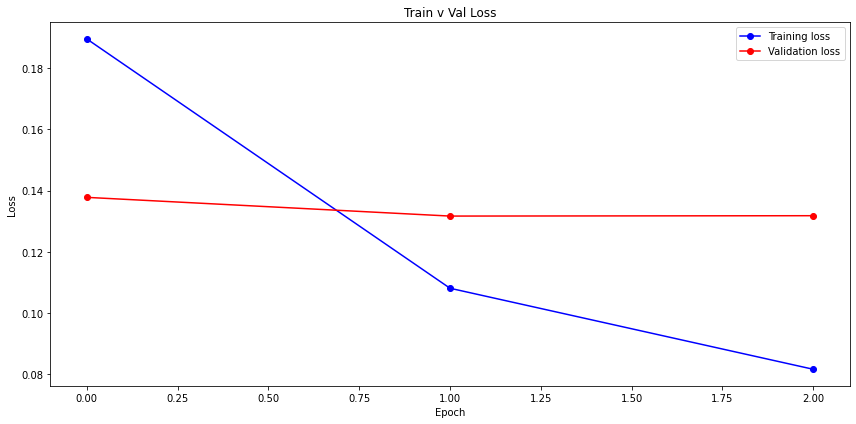

In [36]:
import matplotlib.pyplot as plt
%matplotlib inline


plt.rcParams["figure.figsize"] = (12, 6)
plt.plot(loss_values, 'b-o', label='Training loss')
plt.plot(validation_loss_values, 'r-o', label='Validation loss')

plt.title('Train v Val Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()

### Inference

In [0]:
def ner(sentence):
    tokenized_sentence = tokenizer.encode(sentence)
    input_ids = torch.tensor([tokenized_sentence]).cuda()

    with torch.no_grad():
        output = model(input_ids)
        label_indices = np.argmax(output[0].to('cpu').numpy(), axis=2)

    tokens = tokenizer.convert_ids_to_tokens(input_ids.to('cpu').numpy()[0])
    new_tokens, new_labels = [], []
    for token, label_idx in zip(tokens, label_indices[0]):
        if token.startswith("##"):
        new_tokens[-1] = new_tokens[-1] + token[2:]
    else:
        new_labels.append(tag_values[label_idx])
        new_tokens.append(token)

    for token, label in zip(new_tokens, new_labels):
    print("{}\t{}".format(label, token))

In [50]:
sentence = """ Bruce Wayne & Barry Allen are members of the Justice League """
ner(sentence)

O	[CLS]
B-per	Bruce
I-per	Wayne
O	&
B-per	Barry
I-per	Allen
O	are
O	members
O	of
O	the
B-org	Justice
I-org	League
O	[SEP]
